In [1]:
# Install necesarry:

import numpy as np
import random
from IPython.display import clear_output
#import gym
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

In [2]:
import os
import math

# Make a folder for the saved models:

current_directory = os.getcwd()

models_folder = current_directory + "/models"
os.makedirs(models_folder, exist_ok=True)

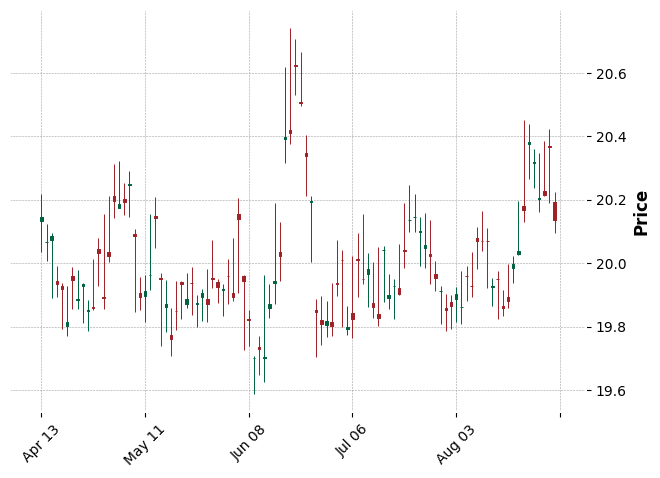

,slug,open,high,low,close,currency
date,,,,,,
2021-04-13,USD/MXN,20.134001,20.217951,20.035299,20.144430,MXN
2021-04-14,USD/MXN,20.067200,20.125280,20.006300,20.067499,MXN
2021-04-15,USD/MXN,20.073099,20.095461,19.891500,20.086060,MXN
2021-04-16,USD/MXN,19.944651,19.989950,19.894400,19.935900,MXN
2021-04-19,USD/MXN,19.929600,19.936550,19.791800,19.918301,MXN


In [3]:
# mplfinance - matplotlib utilities for the visualization, and visual analysis, of financial data
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Call it as:  mpf.plot(data) -- where data is a Pandas DataFrame object containing Open, High, Low and Close data, with a Pandas Datetime Index

# Dataset: https://www.kaggle.com/datasets/dhruvildave/currency-exchange-rates

# Get dataset:
data = pd.read_csv("data/forex.csv")
plot_data = data[-100:].copy() # Last 100 elements of the sequence (index)

# Convert datetime column to datetime format
plot_data['date'] = pd.to_datetime(plot_data['date'])

# Create a DataFrame with datetime as index
df = pd.DataFrame(plot_data)
df.set_index('date', inplace=True)

# Plot candlestick chart
mpf.plot(df, type='candle', style='charles', volume=False)

df.head()

#print("Different currencies in the whole dataset: \n", data['currency'].unique())

# See if we can predict open the next day using RF Regression:

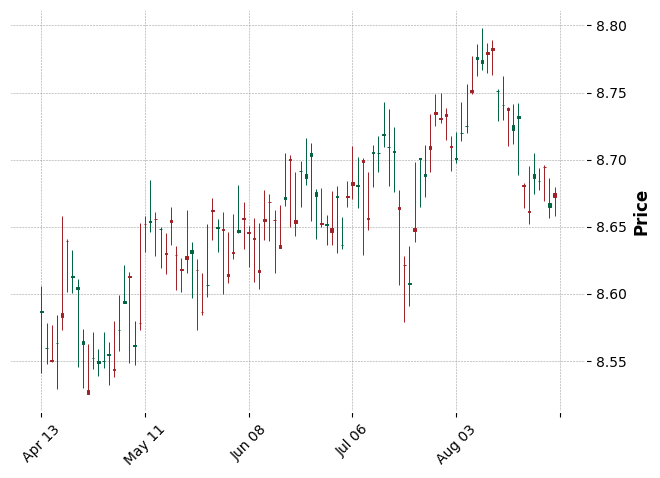

              open     high     low    close
date                                        
2021-04-13  8.5861  8.60610  8.5412  8.58680
2021-04-14  8.5595  8.57850  8.5479  8.55990
2021-04-15  8.5507  8.57650  8.5489  8.55020
2021-04-16  8.5631  8.58400  8.5294  8.56350
2021-04-19  8.5856  8.65780  8.5732  8.58240
...            ...      ...     ...      ...
2021-08-24  8.6866  8.70470  8.6742  8.68920
2021-08-25  8.6838  8.69370  8.6771  8.68400
2021-08-26  8.6947  8.69630  8.6691  8.69450
2021-08-27  8.6648  8.68640  8.6567  8.66730
2021-08-30  8.6748  8.67972  8.6583  8.67206

[100 rows x 4 columns]


In [4]:
# Get data - literally the same as before:

# Select only DKK currency:
df_dkk_open = data[(data['currency'] == 'DKK')].copy()

plot_data_dkk_open = df_dkk_open[-100:].copy() # Last 100 elements of the sequence (index)

# Drop 'slug' and 'currency', as we already know what currency it is:
plot_data_dkk_open = plot_data_dkk_open.drop(['slug', 'currency'], axis = 1)

# Convert datetime column to datetime format
plot_data_dkk_open['date'] = pd.to_datetime(plot_data_dkk_open['date'])

# Create a DataFrame with datetime as index
df_currency_open = pd.DataFrame(plot_data_dkk_open)
df_currency_open.set_index('date', inplace=True)


# Plot candlestick chart
mpf.plot(df_currency_open, type='candle', style='charles', volume=False)

print(df_currency_open)

In [5]:
# In the same row we need next days open. This is what we want to predict, 
# i.e. X = open, high, low, close
# Y = next day's open

# Create a new column 'next_open' with the next day's 'open' value
df_currency_open['next_open'] = df_currency_open['open'].shift(-1)

# The last row will have a NaN value (for obvious reasons):
df_currency_open = df_currency_open.dropna()

# Display the resulting DataFrame
print(df_currency_open)

              open    high     low   close  next_open
date                                                 
2021-04-13  8.5861  8.6061  8.5412  8.5868     8.5595
2021-04-14  8.5595  8.5785  8.5479  8.5599     8.5507
2021-04-15  8.5507  8.5765  8.5489  8.5502     8.5631
2021-04-16  8.5631  8.5840  8.5294  8.5635     8.5856
2021-04-19  8.5856  8.6578  8.5732  8.5824     8.6392
...            ...     ...     ...     ...        ...
2021-08-23  8.6616  8.6952  8.6521  8.6611     8.6866
2021-08-24  8.6866  8.7047  8.6742  8.6892     8.6838
2021-08-25  8.6838  8.6937  8.6771  8.6840     8.6947
2021-08-26  8.6947  8.6963  8.6691  8.6945     8.6648
2021-08-27  8.6648  8.6864  8.6567  8.6673     8.6748

[99 rows x 5 columns]


In [6]:
# Basic data management on df_currency (extract features and labels):

df_currency_open.describe()

# Labels are the values we want to predict
labels = np.array(df_currency_open['next_open'])

# Remove the labels from the features (df_currency is a copy of the actual data, so we do not remove it from the actual dataset)
# axis 1 refers to the columns
features = df_currency_open.drop('next_open', axis = 1) 

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Training and testing sets:

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# train_features = X_train, test_features = X_test, train_labels = Y_train, test_labels = Y_test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42) # test_size, random_state?

# Should be correct: Training features number of columns should match the testing feature number of columns and the number of rows 
# to match for the respective training and testing features and the labels (we have 4 features now):

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (79, 4)
Training Labels Shape: (79,)
Testing Features Shape: (20, 4)
Testing Labels Shape: (20,)


In [7]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)

regressor.fit(train_features, train_labels)

# Access the OOB Score
print("Keep in mind, variance is extremely low in the data:")
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the test data
predictions = regressor.predict(test_features)

# Evaluating the model
mse = mean_squared_error(test_labels, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Calculate the R-squared score
r2 = r2_score(test_labels, predictions)
print(f'R-squared: {r2}')

comparison_df =  pd.DataFrame({'Predicted': predictions, 'Actual': test_labels})

print(f'\n Comparisons: \n', comparison_df)

Keep in mind, variance is extremely low in the data:
Out-of-Bag Score: 0.8990039420549609
Mean Squared Error: 0.0001127714532000254
Root Mean Squared Error: 0.010619390434484711
R-squared: 0.9694599184129606

 Comparisons: 
     Predicted  Actual
0    8.657903  8.6566
1    8.635058  8.6415
2    8.695292  8.6838
3    8.561850  8.5781
4    8.685854  8.6648
5    8.770009  8.7723
6    8.691361  8.7050
7    8.632680  8.6560
8    8.549284  8.5486
9    8.569747  8.5595
10   8.605446  8.6066
11   8.730501  8.7310
12   8.691984  8.7001
13   8.622143  8.6184
14   8.659560  8.6553
15   8.632676  8.6392
16   8.639470  8.6482
17   8.549561  8.5544
18   8.741878  8.7404
19   8.670621  8.6876


In [8]:
# Se om du ihvertfald kan se om den kan se om prisen stiger/falder rigtigt, og hvor ofte dette gælder
# Add predicted to data_frame:

# Assume that test_features and test_labels are aligned
# Create a DataFrame for test features and labels
test_df = pd.DataFrame(test_features, columns=['open', 'high', 'low', 'close'])
test_df['next_open'] = test_labels
test_df['predicted_next_open'] = predictions

# Determine actual direction (up or down)
test_df['actual_direction'] = np.where(test_df['next_open'] > test_df['close'], 'up', 'down')

# Determine predicted direction (up or down)
test_df['predicted_direction'] = np.where(test_df['predicted_next_open'] > test_df['close'], 'up', 'down')

# Check if the prediction was correct
test_df['correct_prediction'] = test_df['actual_direction'] == test_df['predicted_direction']

# Calculate the accuracy of direction prediction
direction_accuracy = test_df['correct_prediction'].mean()

# Display the DataFrame with comparisons
print(test_df[['close', 'next_open', 'predicted_next_open', 'actual_direction', 'predicted_direction', 'correct_prediction']])

print(f'\nPrediction Accuracy (Direction): {direction_accuracy * 100:.2f}%')

      close  next_open  predicted_next_open actual_direction  \
0   8.69850     8.6566             8.657903             down   
1   8.64550     8.6415             8.635058             down   
2   8.68920     8.6838             8.695292             down   
3   8.56170     8.5781             8.561850               up   
4   8.69450     8.6648             8.685854             down   
5   8.77620     8.7723             8.770009             down   
6   8.70560     8.7050             8.691361             down   
7   8.61606     8.6560             8.632680               up   
8   8.55230     8.5486             8.549284             down   
9   8.58680     8.5595             8.569747             down   
10  8.58630     8.6066             8.605446               up   
11  8.73400     8.7310             8.730501             down   
12  8.67210     8.7001             8.691984               up   
13  8.62880     8.6184             8.622143             down   
14  8.66860     8.6553             8.659

# Predict relationship between USD, EUR, CNY & JPY -- with hyperparameter tuning using GridSearchCV

##### I.e. between USD/EUR, USD/CNY, USD/JPY i guess???

In [9]:
#print("Different slugs in the whole dataset: \n", data['slug'].unique())

c:\Users\ander\AppData\Local\Programs\Python\Python312\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


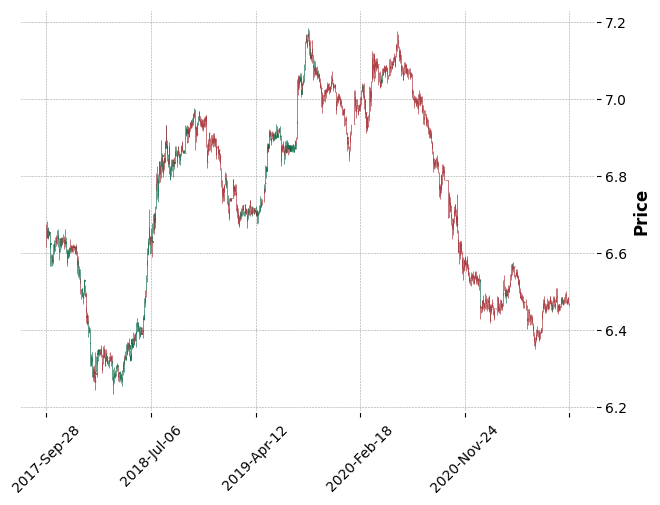

              open    high     low   close
date                                      
2017-09-28  6.6407  6.6755  6.6160  6.6405
2017-09-29  6.6636  6.6834  6.6386  6.6650
2017-10-02  6.6388  6.6646  6.6388  6.6578
2017-10-03  6.6534  6.6624  6.6372  6.6517
2017-10-04  6.6506  6.6671  6.6390  6.6511
...            ...     ...     ...     ...
2021-08-24  6.4800  6.4832  6.4686  6.4800
2021-08-25  6.4699  6.4783  6.4675  6.4699
2021-08-26  6.4749  6.4856  6.4725  6.4749
2021-08-27  6.4805  6.4867  6.4694  6.4805
2021-08-30  6.4711  6.4717  6.4620  6.4658

[1000 rows x 4 columns]


In [10]:
# Select only USD/CNY currency:

df_USD_CNY = data[(data['slug'] == 'USD/CNY')].copy()

plot_USD_CNY = df_USD_CNY[-1000:].copy() 

# Drop 'slug' and 'currency', as we already know what currency/slug it is:
plot_USD_CNY = plot_USD_CNY.drop(['slug', 'currency'], axis = 1)

# Convert datetime column to datetime format
plot_USD_CNY['date'] = pd.to_datetime(plot_USD_CNY['date'])

# Create a DataFrame with datetime as index
df_USD_CNY_open = pd.DataFrame(plot_USD_CNY)
df_USD_CNY_open.set_index('date', inplace=True)

# Plot candlestick chart
mpf.plot(df_USD_CNY_open, type='candle', style='charles', volume=False)

print(df_USD_CNY_open)

In [11]:
# In the same row we need next days open. This is what we want to predict, 
# i.e. X = open, high, low, close
# Y = next day's open

# Create a new column 'next_open' with the next day's 'open' value
df_USD_CNY_open['next_open'] = df_USD_CNY_open['open'].shift(-1)

# The last row will have a NaN value (for obvious reasons):
df_USD_CNY_open = df_USD_CNY_open.dropna()

# Display the resulting DataFrame
print(df_USD_CNY_open)

              open    high     low   close  next_open
date                                                 
2017-09-28  6.6407  6.6755  6.6160  6.6405     6.6636
2017-09-29  6.6636  6.6834  6.6386  6.6650     6.6388
2017-10-02  6.6388  6.6646  6.6388  6.6578     6.6534
2017-10-03  6.6534  6.6624  6.6372  6.6517     6.6506
2017-10-04  6.6506  6.6671  6.6390  6.6511     6.6534
...            ...     ...     ...     ...        ...
2021-08-23  6.4916  6.4954  6.4715  6.4916     6.4800
2021-08-24  6.4800  6.4832  6.4686  6.4800     6.4699
2021-08-25  6.4699  6.4783  6.4675  6.4699     6.4749
2021-08-26  6.4749  6.4856  6.4725  6.4749     6.4805
2021-08-27  6.4805  6.4867  6.4694  6.4805     6.4711

[999 rows x 5 columns]


In [26]:
# Basic data management on df_currency (extract features and labels):

df_USD_CNY_open.describe()

# Labels are the values we want to predict
labels = np.array(df_USD_CNY_open['next_open'])

# Remove the labels from the features (df_currency is a copy of the actual data, so we do not remove it from the actual dataset)
# axis 1 refers to the columns
features = df_USD_CNY_open.drop('next_open', axis = 1) 

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

# Training and testing sets:

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# train_features = X_train, test_features = X_test, train_labels = Y_train, test_labels = Y_test
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42) # test_size, random_state?

# Should be correct: Training features number of columns should match the testing feature number of columns and the number of rows 
# to match for the respective training and testing features and the labels (we have 4 features now):

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (799, 4)
Training Labels Shape: (799,)
Testing Features Shape: (200, 4)
Testing Labels Shape: (200,)


In [33]:
from sklearn.model_selection import RandomizedSearchCV

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(random_state=42, oob_score=False)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# RandomizedSearchCV for faster results
random_search = RandomizedSearchCV(
    estimator=regressor,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=10,       # 5-fold cross-validation
    scoring='r2',  # R-squared score as evaluation metric
    verbose=2,
    n_jobs=-1,  # Use all available cores
    random_state=42
)

random_search.fit(train_features, train_labels)

# Get the best model after RandomizedSearchCV
best_model = random_search.best_estimator_

# Access the OOB Score
print("Keep in mind, variance is extremely low in the data:")

# Making predictions on the test data
predictions = best_model.predict(test_features)

# Evaluating the model
mse = mean_squared_error(test_labels, predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Calculate the R-squared score
r2 = r2_score(test_labels, predictions)
print(f'R-squared: {r2}')

comparison_df =  pd.DataFrame({'Predicted': predictions, 'Actual': test_labels})

print(f'\n Comparisons: \n', comparison_df)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Keep in mind, variance is extremely low in the data:
Mean Squared Error: 0.00014523899439793285
Root Mean Squared Error: 0.012051514195234259
R-squared: 0.9973819554186509

 Comparisons: 
      Predicted  Actual
0     6.877972  6.8760
1     6.627084  6.6054
2     6.738553  6.7729
3     6.880569  6.8817
4     6.829176  6.8275
..         ...     ...
195   6.437451  6.4323
196   6.636538  6.6256
197   6.938040  6.9374
198   6.860377  6.8589
199   6.872252  6.8662

[200 rows x 2 columns]


In [34]:
# Se om du ihvertfald kan se om den kan se om prisen stiger/falder rigtigt, og hvor ofte dette gælder
# Add predicted to data_frame:

# Assume that test_features and test_labels are aligned
# Create a DataFrame for test features and labels
test_df = pd.DataFrame(test_features, columns=['open', 'high', 'low', 'close'])
test_df['next_open'] = test_labels
test_df['predicted_next_open'] = predictions

# Determine actual direction (up or down)
test_df['actual_direction'] = np.where(test_df['next_open'] > test_df['close'], 'up', 'down')

# Determine predicted direction (up or down)
test_df['predicted_direction'] = np.where(test_df['predicted_next_open'] > test_df['close'], 'up', 'down')

# Check if the prediction was correct
test_df['correct_prediction'] = test_df['actual_direction'] == test_df['predicted_direction']

# Calculate the accuracy of direction prediction
direction_accuracy = test_df['correct_prediction'].mean()

# Display the DataFrame with comparisons
print(test_df[['close', 'next_open', 'predicted_next_open', 'actual_direction', 'predicted_direction', 'correct_prediction']])

print(f'\nPrediction Accuracy (Direction): {direction_accuracy * 100:.2f}%')

      close  next_open  predicted_next_open actual_direction  \
0    6.8791     6.8760             6.877972             down   
1    6.6106     6.6054             6.627084             down   
2    6.7177     6.7729             6.738553               up   
3    6.8558     6.8817             6.880569               up   
4    6.8477     6.8275             6.829176             down   
..      ...        ...                  ...              ...   
195  6.4423     6.4323             6.437451             down   
196  6.6398     6.6256             6.636538             down   
197  6.9465     6.9374             6.938040             down   
198  6.8679     6.8589             6.860377             down   
199  6.8749     6.8662             6.872252             down   

    predicted_direction  correct_prediction  
0                  down                True  
1                    up               False  
2                    up                True  
3                    up                True  
4